In [1]:
import torch
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import torch.nn.functional as F
from collections import defaultdict
import copy
import sys
from scipy import ndimage
cmap=plt.cm.Spectral_r
from mpl_toolkits import mplot3d
from pathlib import Path
from utils import get_data
from main import test
from models import FullyConnected
import string

sys.path.append('.')
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
    #"text.usetex": True,
    "font.family": "serif",
    'font.size':12,
    "lines.linewidth":3.0,
    "savefig.dpi":500
})
cmap = plt.get_cmap('Spectral_r')

savedir= './figs/'
if not os.path.exists(savedir):
    os.mkdir(savedir)

# Helpers

In [2]:
def find(array, value):
    idx= np.argwhere(np.array(array)==value)[0,0]
    return idx

def h2p(width, input_size, depth):
    return input_size*width + (depth-1) * width**2 + width
h2p = np.vectorize(h2p)

def select_runs(runs, params, constraints):
    selected_runs = []
    for irun, run in enumerate(runs):
        keep = True
        for k,v in constraints.items():
            if getattr(run['args'],k) != v:
                keep = False
                break
        if keep:
            selected_runs.append(run)
    selected_params = copy.deepcopy(params)
    for con in constraints:
        selected_params[con]=[constraints[con]]
    return selected_runs, selected_params

def group_runs(runs, finished_only=True):
    runs_grouped = defaultdict(list)
    for run in runs:
        seedless_args = copy.deepcopy(run['args'])
        del(seedless_args.seed)
        del(seedless_args.name)
        if str(seedless_args) not in runs_grouped.keys(): 
            runs_grouped[str(seedless_args)].append(run) # need at least one run
        else:
            if run['finished'] or not finished_only:
                runs_grouped[str(seedless_args)].append(run)
    runs_grouped = list(runs_grouped.values())
    return runs_grouped

def flatten(weights, layer=None):
    if layer is None:
        return torch.cat([w.view(-1) for w in weights.values()])
    else: 
        return list(weights.values())[layer].view(-1)

def interpolate(w1, w2, alpha):
    w3 = copy.deepcopy(w1)
    for (k1,p1), (k2,p2) in zip(w1.items(), w2.items()):
        w3[k1] = alpha * p1 + (1-alpha) * p2
    return w3

def last_non_nan(array):
    return (~np.isnan(array)).cumsum(1).argmax(1)

def calc_ens_acc(group, test_loader):
    args = group[0]['args']
    x,y = list(test_loader)[0]
    for run in group:
        model = FullyConnected(input_size = input_channels * input_size**2,
                       output_size=output_size, hidden_size=args.hidden_size, n_layers=args.n_layers,
                       training_method=args.training_method, activation=args.activation, 
                       feedback_init=args.feedback_init, weight_init = args.weight_init)
        model.load_state_dict(run['weights'])
        outs.append(model(x))
    y_pred = torch.stack(outs).mean(dim=0).max(1)[1]
    ens_acc = y_pred.eq(y).sum().float()/len(y)*100
    return ens_acc

def calc_weight_alignments(group):
    if not isinstance(group,list):
        group = [group]
    args = group[0]['args']
    alignments = {l:[] for l in range(1,args.n_layers)}
    for run in group:  
        b = run['feedback_matrix']
        if type(run['weights'])==list: weights = run['weights'][-1]
        else: weights = run['weights']
        for l in range(1,args.n_layers):
            w = weights['layers.{}.weight'.format(l)].view(-1)
            if l == args.n_layers-1:
                v = b[-1].view(-1)
            else:
                v = (b[l].t()@b[l-1]).view(-1)
            a = w @ v / w.norm() / v.norm()
            if np.isnan(a):
                print('nan ', end=' ')
                continue
            alignments[l].append(a)
    return alignments

def calc_time_angles(group):

    angles = defaultdict(list)
    for t in group[0]['weights']:
        angles_tmp = []
        weights = []
        for run in group:
            try: weights.append(run['weights'][t])
            except: continue
        for i1, w1 in enumerate(weights):
            for i2, w2 in enumerate(weights):
                if i1<=i2: continue
                angle = flatten(w1)@flatten(w2).t()/flatten(w1).norm()/flatten(w2).norm()
                if not np.isnan(angle):
                    angles_tmp.append(angle.item())
        angles[t]=np.nanmean(angles_tmp)
    return angles

def calc_time_norms(group, compare_to=None, layer=None):

    norms = defaultdict(list)
    for t in group[0]['weights']:
        norms_tmp = []
        for run in group:
            try: weights = flatten(run['weights'][t], layer=layer)
            except: continue
            if compare_to == 'init':
                weights -= flatten(run['weights'][0], layer=layer)
            elif compare_to == 'final': 
                final = max(list(run['weights'].keys()))
                weights -= flatten(run['weights'][final], layer=layer)
            elif compare_to is None: pass
            else: raise NotImplementedError
            norm = weights.norm().item()
            norms_tmp.append(norm)
        norms[t]=np.nanmean(norms_tmp)
    return norms

def calc_final_angles(group):

    weights = []
    angles = defaultdict(list)
    for run in group:
        if type(run['weights'])==list: 
            weights.append(run['weights'][-1])
        else: 
            weights.append(run['weights'])
    for i1, w1 in enumerate(weights):
        for i2, w2 in enumerate(weights):
            if i1<=i2: continue
            angle = flatten(w1)@flatten(w2).t()/flatten(w1).norm()/flatten(w2).norm()
            if not np.isnan(angle):
                angles['total'].append(angle.item())
            for l, (p1, p2) in enumerate(zip(w1.values(), w2.values())):
                angle = p1.view(-1) @ p2.view(-1).t()/p1.norm()/p2.norm().item()
                if not np.isnan(angle):
                    angles[l].append(angle.item())
    return angles

# Load runs

In [3]:
#r.1599816645 comparing init methods
#r.1599829961 same with 5 layers
#r.1600436153 noise run bs 128
#r.1600442941 noise run bs 1
#r.1601044019 alphabeta
#r.1601390533 random feedback init
#r.1601451448 orthogonal feedback init
#r.1601537383 uniform feedback init
#r.1601590379 smaller input size, MNIST
#r.1601626936 angles vs time

# FINAL r.1602582325 angles vs time
# FINAL r.1601983411 alphabeta
# FINAL r.1601976778 noise

paths = sorted(glob.glob('r.*'), key=os.path.getmtime)
last = paths[-1]
path = last
#path = 'r.1601881610'
path+='/'
print(path)

def load_runs(path):

    runs = []
    params = torch.load(path+'params.pkl')
    for k, v in params.items():
        print(k,v)
    files = glob.glob(path + '*.pyT')
    for ifile, file in enumerate(files):
        if ifile%(len(files)//4)==0:
            print(ifile, 'out of', len(files))
        try:
            run = torch.load(file)
        except:
            continue
        torch.save(run, file)
        runs.append(run)

    return runs, params

#runs, params = load_runs(path)

r.1603991071/


# Dynamics at fixed width

In [4]:
path = 'r.1602582325/'
runs, params = load_runs(path)

seed range(0, 10)
hidden_size [100]
n_layers [4]
activation ['relu', 'tanh']
dataset ['MNIST', 'CIFAR10']
epochs [10000]
n_saves [40]
training_method ['BP', 'DFA']
feedback_init ['UNIFORM']
weight_init ['UNIFORM']
learning_rate [0.0001]
momentum [0.0]
batch_size [32]
test_batch_size [1000]
model ['fc']
no_gpu [False]
dataset_path ['~/data']
datasize [None]
num_classes [10]
label_noise [0.0, 0.1, 0.2, 0.5, 0.9]
input_dim [14]
optimizer ['SGD']
task ['CLASSIFICATION']
0 out of 400
100 out of 400
200 out of 400
300 out of 400


# All dynamics

0 out of 8
1 out of 8
2 out of 8
3 out of 8
4 out of 8
5 out of 8
6 out of 8
7 out of 8


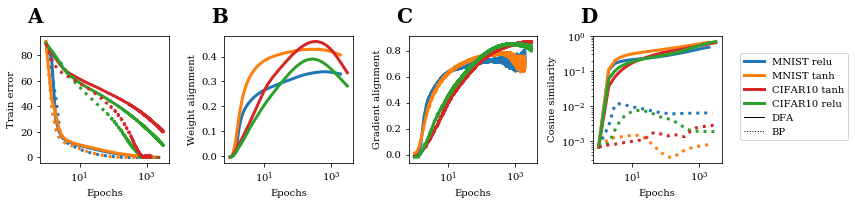

0 out of 8
1 out of 8
2 out of 8
3 out of 8
4 out of 8
5 out of 8
6 out of 8
7 out of 8


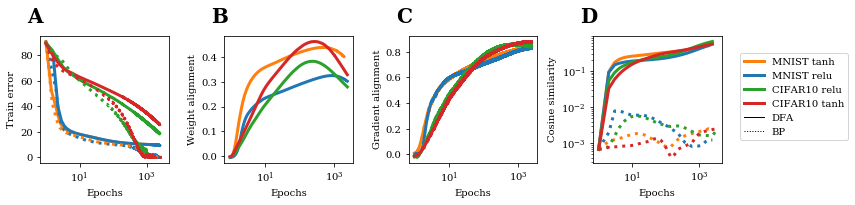

0 out of 8
1 out of 8
2 out of 8
3 out of 8
4 out of 8
5 out of 8
6 out of 8
7 out of 8


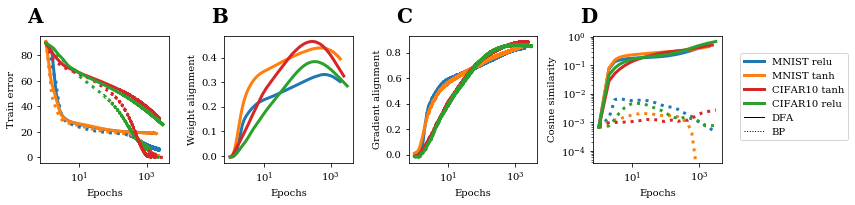

0 out of 8


/private/home/sdascoli/.conda/envs/df/lib/python3.7/site-packages/ipykernel_launcher.py:104: RuntimeWarning: Mean of empty slice


1 out of 8
2 out of 8
3 out of 8
4 out of 8
5 out of 8
6 out of 8
7 out of 8


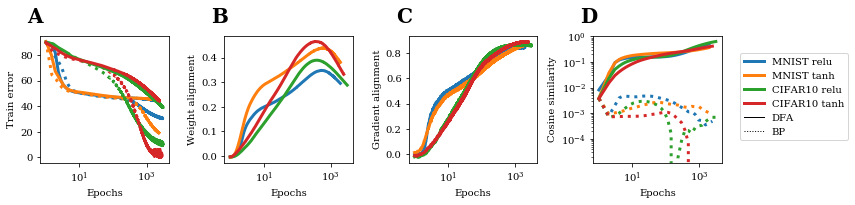

0 out of 8
1 out of 8
2 out of 8
3 out of 8
4 out of 8
5 out of 8
6 out of 8
7 out of 8


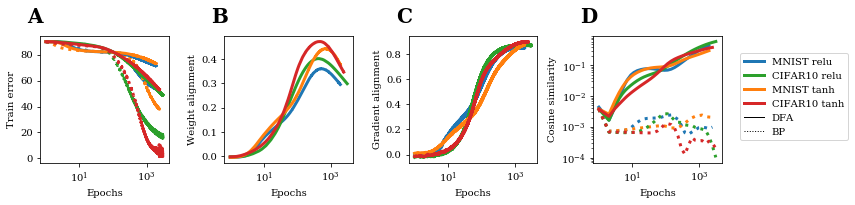

In [39]:
for label_noise in [0,0.1,0.2,0.5,0.9]:

    constraints = {'label_noise':label_noise}
    selected_runs, _ = select_runs(runs, params, constraints)
    grouped_runs = group_runs(selected_runs, finished_only=False)

    angle_dict = {}
    train_acc_dict = {}
    wa_dict = {}
    ga_dict = {}

    for igroup, group in enumerate(grouped_runs):
        print(igroup, 'out of', len(grouped_runs))
        args = group[0]['args']
        key  =(args.dataset, args.activation, args.training_method)
        ls   = '-' if args.training_method == 'DFA' else ':'

        shortest = min([len(run['train_accs']) for run in group])
        train_acc_dict[key] = np.mean(np.array([run['train_accs'][:shortest] for run in group]), axis=0)
        if args.training_method == 'DFA':
            wa_dict[key] = np.mean(np.array([run['weight_alignments']['total'][:shortest] for run in group]), axis=0)
            ga_dict[key] = np.mean(np.array([run['grad_alignments']  ['total'][:shortest] for run in group]), axis=0)

        angle_dict[key] = calc_time_angles(group)


    fig, axarr = plt.subplots(1,4, figsize=(12,3))
    colors = {'MNIST relu':'C0', 'MNIST tanh':'C1', 'CIFAR10 relu':'C2', 'CIFAR10 tanh':'C3'}

    for key in angle_dict.keys():
        label = '{} {}'.format(key[0], key[1])
        color= colors[label]
        ls = '-' if key[2] == 'DFA' else ':'

        epochs1 = [k+1  for k in angle_dict[key].keys()]
        epochs = np.linspace(0, max(epochs1), len(train_acc_dict[key]))+1
        axarr[0].plot(epochs[::10], 100-train_acc_dict[key][::10], color=color, ls=ls)
        if key[2]=='DFA':
            axarr[1].plot(epochs, wa_dict[key], color=color, ls=ls)
            axarr[2].plot(epochs, ga_dict[key], color=color, ls=ls)    
            axarr[3].plot(epochs1, list(angle_dict[key].values()), 
                          label=(label if key[2]=='DFA' else ''), color=color, ls=ls)
        else: 
            axarr[3].plot([k+1  for k in angle_dict[key].keys()], list(angle_dict[key].values()),
                          color=color, ls=ls)

    axarr[3].plot([],[],color='k', lw=1, label='DFA')
    axarr[3].plot([],[],color='k', ls=':', lw=1, label='BP')
    axarr[3].legend(bbox_to_anchor=(1.1,.9))

    for i, ax in enumerate(axarr):
        ax.set_xscale('log')
        ax.set_xlabel('Epochs')
        ax.text(-0.1, 1.1, string.ascii_uppercase[i], transform=ax.transAxes, size=20, weight='bold')
    axarr[3].set_yscale('log')

    axarr[0].set_ylabel('Train error')
    axarr[1].set_ylabel('Weight alignment')
    axarr[2].set_ylabel('Gradient alignment')
    axarr[3].set_ylabel('Cosine similarity')

    plt.tight_layout()
    plt.savefig(savedir+'Dynamics_full_noise_{}.pdf'.format(label_noise), bbox_inches='tight')
    plt.show()

# Similarity

0 out of 8
1 out of 8
2 out of 8
3 out of 8
4 out of 8
5 out of 8
6 out of 8
7 out of 8


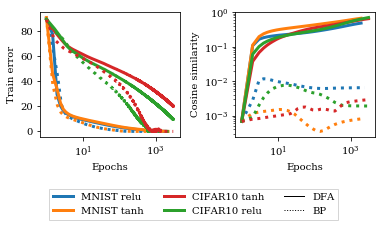

0 out of 8
1 out of 8
2 out of 8
3 out of 8
4 out of 8
5 out of 8
6 out of 8
7 out of 8


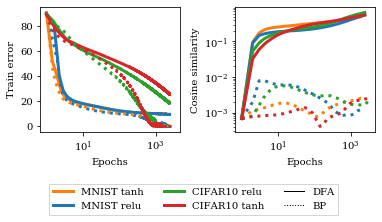

0 out of 8
1 out of 8
2 out of 8
3 out of 8
4 out of 8
5 out of 8
6 out of 8
7 out of 8


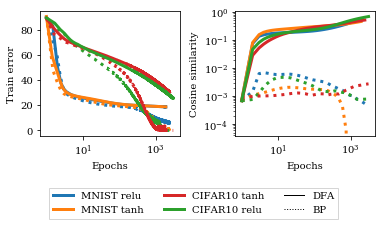

0 out of 8


/private/home/sdascoli/.conda/envs/df/lib/python3.7/site-packages/ipykernel_launcher.py:104: RuntimeWarning: Mean of empty slice


1 out of 8
2 out of 8
3 out of 8
4 out of 8
5 out of 8
6 out of 8
7 out of 8


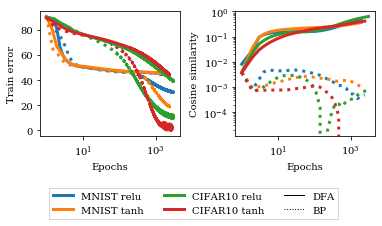

0 out of 8
1 out of 8
2 out of 8
3 out of 8
4 out of 8
5 out of 8
6 out of 8
7 out of 8


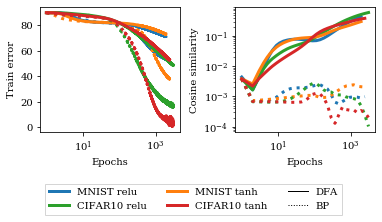

In [36]:
for label_noise in [0,0.1,0.2,0.5,0.9]:

    constraints = {'label_noise':label_noise}
    selected_runs, _ = select_runs(runs, params, constraints)
    grouped_runs = group_runs(selected_runs, finished_only=False)

    angle_dict = {}
    train_acc_dict = {}
    wa_dict = {}
    ga_dict = {}

    for igroup, group in enumerate(grouped_runs):
        print(igroup, 'out of', len(grouped_runs))
        args = group[0]['args']
        key  =(args.dataset, args.activation, args.training_method)
        ls   = '-' if args.training_method == 'DFA' else ':'

        shortest = min([len(run['train_accs']) for run in group])
        train_acc_dict[key] = np.mean(np.array([run['train_accs'][:shortest] for run in group]), axis=0)
        angle_dict[key] = calc_time_angles(group)


    fig, axarr = plt.subplots(1,2, figsize=(6,3))
    colors = {'MNIST relu':'C0', 'MNIST tanh':'C1', 'CIFAR10 relu':'C2', 'CIFAR10 tanh':'C3'}

    for key in angle_dict.keys():
        label = '{} {}'.format(key[0], key[1])
        color= colors[label]
        ls = '-' if key[2] == 'DFA' else ':'

        epochs1 = [k+1  for k in angle_dict[key].keys()]
        epochs = np.linspace(0, max(epochs1), len(train_acc_dict[key]))+1
        axarr[0].plot(epochs[::10], 100-train_acc_dict[key][::10], color=color, ls=ls)
        if key[2]=='DFA':
            axarr[1].plot(epochs1, list(angle_dict[key].values()), 
                          color=color, ls=ls, label=(label if key[2]=='DFA' else ''), )
        else: 
            axarr[1].plot([k+1  for k in angle_dict[key].keys()], list(angle_dict[key].values()),
                          color=color, ls=ls)nknc

    axarr[1].plot([],[],color='k', lw=1, label='DFA')
    axarr[1].plot([],[],color='k', ls=':', lw=1, label='BP')
    
    fig.subplots_adjust(bottom=0.3, wspace=.4)
    axarr[1].legend(loc='lower center', 
             bbox_to_anchor=(-.3, -0.7),fancybox=False, shadow=False, ncol=3)
    #axarr[0].legend(bbox_to_anchor=(0.1,-.4), ncol=3)

    for i, ax in enumerate(axarr):
        ax.set_xscale('log')
        ax.set_xlabel('Epochs')
        #ax.text(-0.1, 1.1, string.ascii_uppercase[i], transform=ax.transAxes, size=20, weight='bold')
    axarr[1].set_yscale('log')

    axarr[0].set_ylabel('Train error')
    axarr[1].set_ylabel('Cosine similarity')

    #plt.tight_layout()
    plt.savefig(savedir+'Dynamics_similarity_noise_{}.pdf'.format(label_noise), bbox_inches='tight')
    plt.show()

# Alignment

0 out of 4
1 out of 4
2 out of 4
3 out of 4


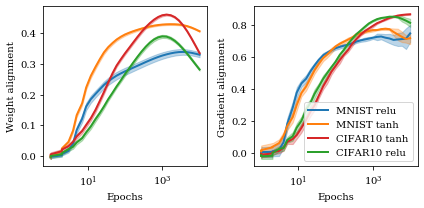

0 out of 4
1 out of 4
2 out of 4
3 out of 4


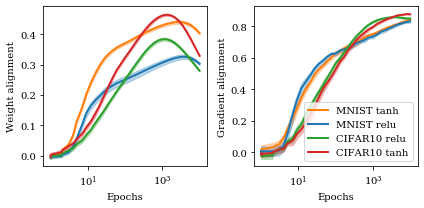

0 out of 4
1 out of 4
2 out of 4
3 out of 4


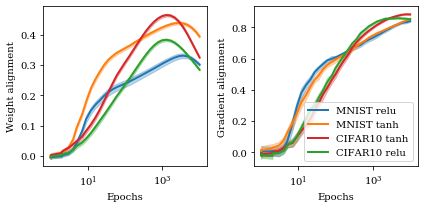

0 out of 4
1 out of 4
2 out of 4
3 out of 4


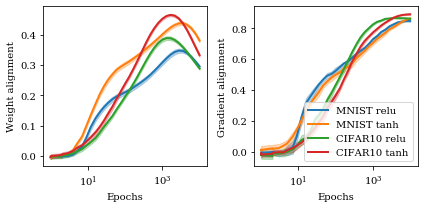

0 out of 4
1 out of 4
2 out of 4
3 out of 4


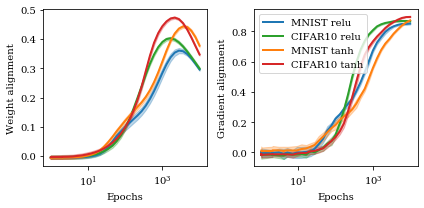

In [99]:
for label_noise in [0,0.1,0.2,0.5,0.9]:

    constraints = {'label_noise':label_noise,
                  'training_method':'DFA'}
    selected_runs, _ = select_runs(runs, params, constraints)
    grouped_runs = group_runs(selected_runs, finished_only=False)

    wa_dict = {}
    ga_dict = {}
    angle_dict = {}

    for igroup, group in enumerate(grouped_runs):
        print(igroup, 'out of', len(grouped_runs))
        args = group[0]['args']
        key  =(args.dataset, args.activation, args.training_method)
        ls   = '-' if args.training_method == 'DFA' else ':'

        shortest = min([len(run['train_accs']) for run in group])
        keep = np.unique(np.logspace(0,np.log10(shortest-1),40).astype(int))
        if args.training_method == 'DFA':
            was = np.array([np.array(run['weight_alignments']['total'])[keep] for run in group])
            gas = np.array([np.array(run['grad_alignments']  ['total'])[keep] for run in group])
            wa_dict[key] = (np.mean(was, axis=0), np.std(was, axis=0))
            ga_dict[key] = (np.mean(gas, axis=0), np.std(gas, axis=0))

    fig, axarr = plt.subplots(1,2, figsize=(6,3))
    colors = {'MNIST relu':'C0', 'MNIST tanh':'C1', 'CIFAR10 relu':'C2', 'CIFAR10 tanh':'C3'}

    for key in wa_dict.keys():
        label = '{} {}'.format(key[0], key[1])
        color= colors[label]
        ls = '-' if key[2] == 'DFA' else ':'

        epochs = np.unique(np.logspace(0,np.log10(args.epochs-1),len(wa_dict[key][0]))).astype(int)
        axarr[0].plot(epochs, wa_dict[key][0], color=color, lw=2, ls=ls)
        axarr[1].plot(epochs, ga_dict[key][0], color=color, lw=2, ls=ls, label=label)  
        axarr[0].fill_between(epochs, wa_dict[key][0]-wa_dict[key][1], wa_dict[key][0]+wa_dict[key][1], color=color, alpha=.3)
        axarr[1].fill_between(epochs, ga_dict[key][0]-ga_dict[key][1], ga_dict[key][0]+ga_dict[key][1], color=color, alpha=.3)  

    axarr[1].legend()

    for i, ax in enumerate(axarr):
        ax.set_xscale('log')
        ax.set_xlabel('Epochs')
        #ax.text(-0.1, 1.1, string.ascii_uppercase[i], transform=ax.transAxes, size=20, weight='bold')

    axarr[0].set_ylabel('Weight alignment')
    axarr[1].set_ylabel('Gradient alignment')

    plt.tight_layout()
    plt.savefig(savedir+'Dynamics_angle_noise_{}.pdf'.format(label_noise), bbox_inches='tight')
    plt.show()

# Layerwise

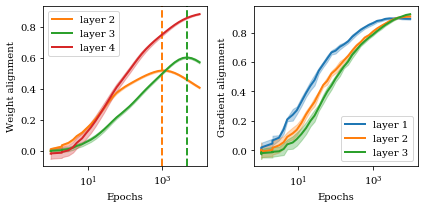

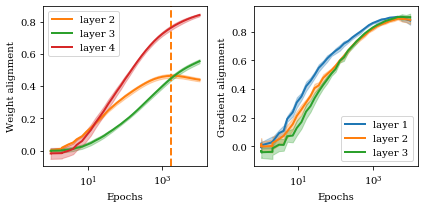

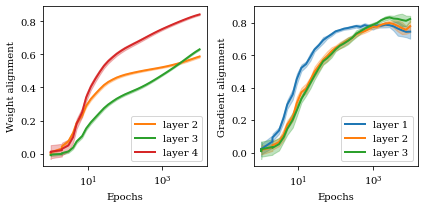

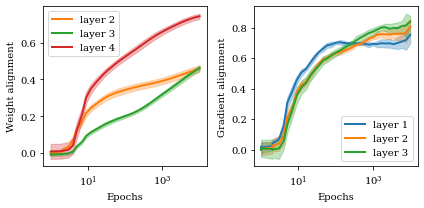

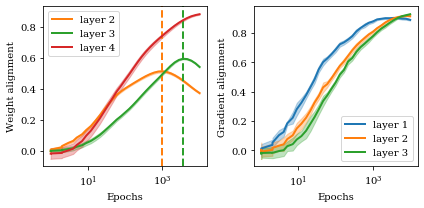

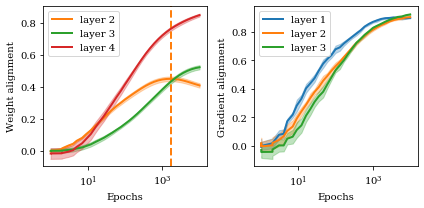

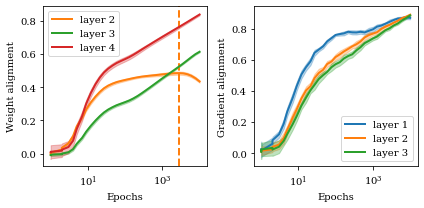

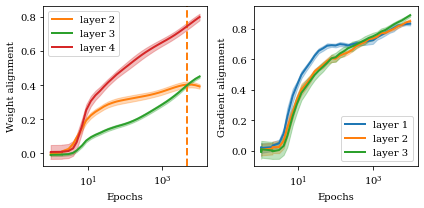

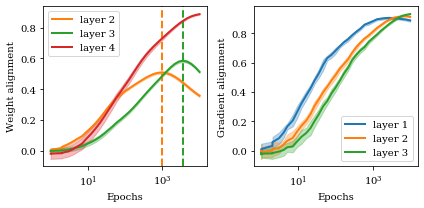

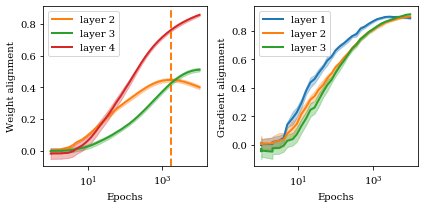

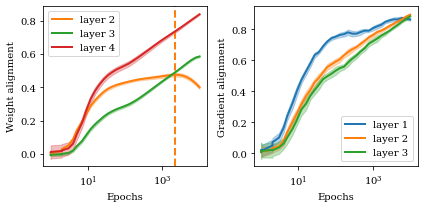

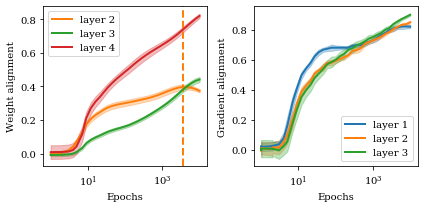

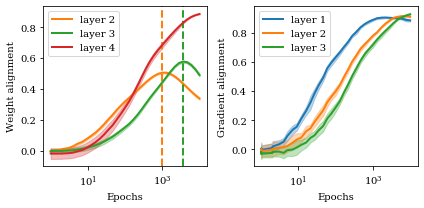

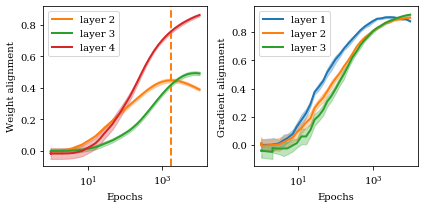

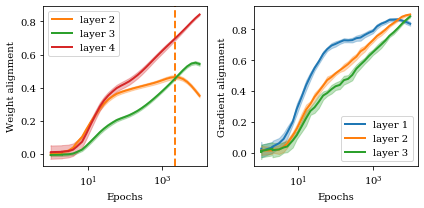

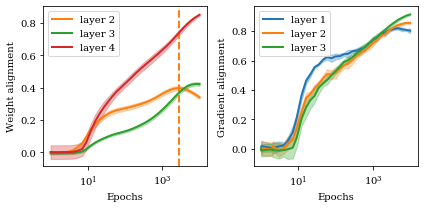

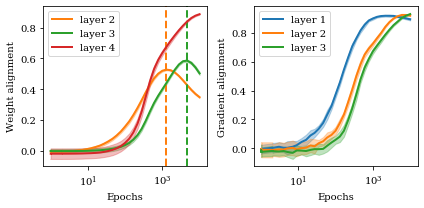

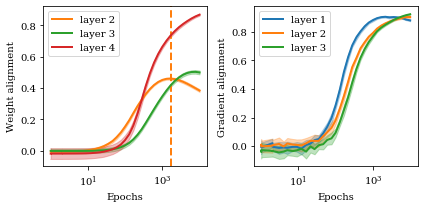

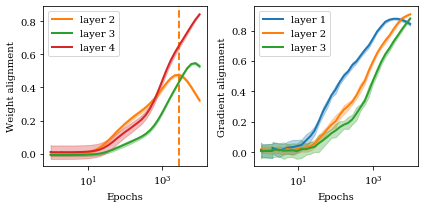

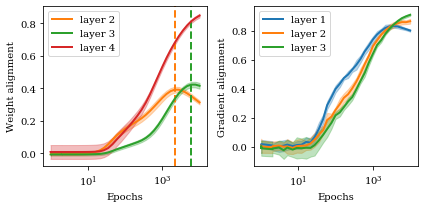

In [104]:
for label_noise in [0,0.1,0.2,0.5,0.9]:
    for dataset in ['CIFAR10', 'MNIST']:
        for activation in ['tanh', 'relu']:
            constraints = {'label_noise':label_noise,
                          'dataset':dataset,
                          'activation':activation}
            selected_runs, _ = select_runs(runs, params, constraints)
            grouped_runs = group_runs(selected_runs, finished_only=False)

            wa_dict = {}
            ga_dict = {}
            dist_dict = {}

            for igroup, group in enumerate(grouped_runs):
                args = group[0]['args']
                shortest = min([len(run['train_accs']) for run in group])
                keep = np.unique(np.logspace(0,np.log10(shortest-1),40).astype(int))
                train_acc_dict = np.mean(np.array([run['train_accs'][:shortest] for run in group]), axis=0)
                for l in range(args.n_layers-1):
                    if args.training_method == 'DFA':
                        was = np.array([np.array(run['weight_alignments'][l])[keep] for run in group])
                        gas = np.array([np.array(run['grad_alignments']  [l])[keep] for run in group])
                        wa_dict[l] = np.mean((was), axis=0), np.std((was), axis=0)
                        ga_dict[l] = np.mean((gas), axis=0), np.std((gas), axis=0)

            fig, axarr = plt.subplots(1,2, figsize=(6,3))
            epochs = np.unique(np.logspace(0,np.log10(args.epochs-1),len(wa_dict[0][0]))).astype(int)
            #epochs = np.linspace(0, args.epochs, len(wa_dict[0][0]))+1
            for l in wa_dict.keys():
                label = '{}'.format(l)
                axarr[0].plot(epochs, wa_dict[l][0], lw=2, label='layer {}'.format(l+2), color='C%d'%(l+1))
                axarr[1].plot(epochs, ga_dict[l][0], lw=2, label='layer {}'.format(l+1), color='C%d'%(l)  ) 
                axarr[0].fill_between(epochs, wa_dict[l][0]-wa_dict[l][1], wa_dict[l][0]+wa_dict[l][1], color='C%d'%(l+1), alpha=.3)
                axarr[1].fill_between(epochs, ga_dict[l][0]-ga_dict[l][1], ga_dict[l][0]+ga_dict[l][1], color='C%d'%(l)  , alpha=.3)
                if (epochs[np.argmax(wa_dict[l][0])] < epochs[-2]):
                    axarr[0].axvline(x=epochs[np.argmax(wa_dict[l])], color='C%d'%(l+1), ls='--', lw=2)

            axarr[0].legend()
            axarr[1].legend()
            for i, ax in enumerate(axarr):
                ax.set_xscale('log')
                ax.set_xlabel('Epochs')
                #ax.text(-0.1, 1.1, string.ascii_uppercase[i], transform=ax.transAxes, size=20, weight='bold')

            axarr[0].set_ylabel('Weight alignment')
            axarr[1].set_ylabel('Gradient alignment')

            plt.tight_layout()
            plt.savefig(savedir+'Dynamics_layerwise_{}_{}_noise_{}.pdf'.format(dataset, activation, label_noise), bbox_inches='tight')
            plt.show()

# Varying label noise

In [200]:
path = 'r.1601976778/'
runs, params = load_runs(path)

seed [0]
hidden_size [100]
n_layers [3]
activation ['linear', 'tanh', 'relu']
dataset ['MNIST', 'CIFAR10']
epochs [1000]
training_method ['DFA']
feedback_init ['UNIFORM']
weight_init ['UNIFORM']
learning_rate [0.0001]
momentum [0.0]
batch_size [32]
test_batch_size [1000]
model ['fc']
no_gpu [False]
dataset_path ['~/data']
datasize [None]
num_classes [None]
label_noise [0, 0.1, 0.2, 0.5, 0.9]
input_dim [None]
optimizer ['SGD']
task ['CLASSIFICATION']
0 out of 30
7 out of 30
14 out of 30
21 out of 30
28 out of 30


/public/apps/anaconda3/2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


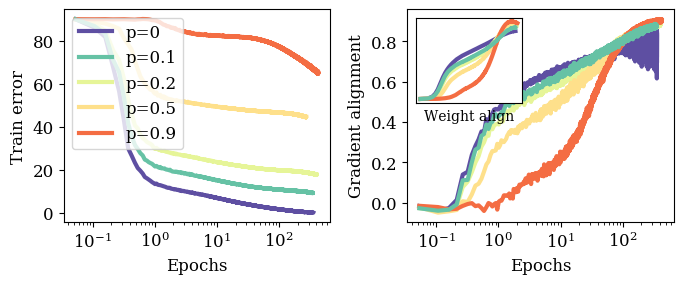

/public/apps/anaconda3/2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


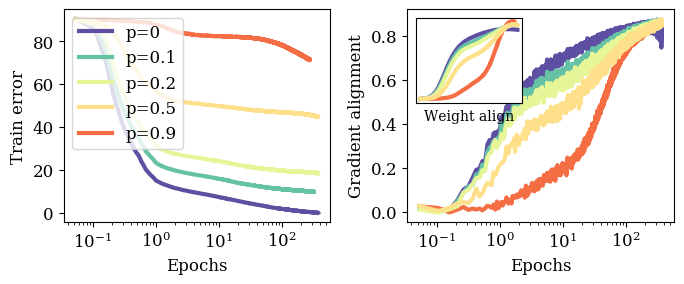

/public/apps/anaconda3/2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


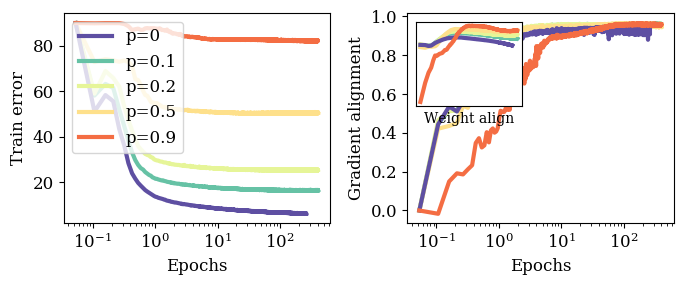

/public/apps/anaconda3/2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


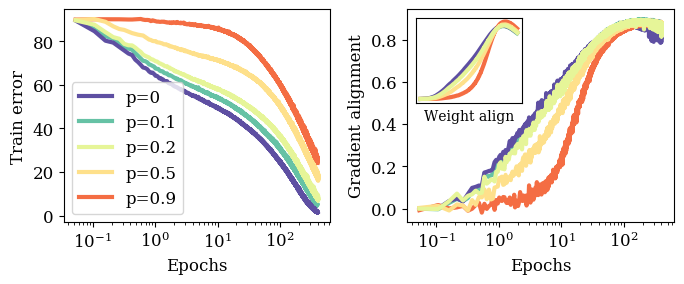

/public/apps/anaconda3/2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


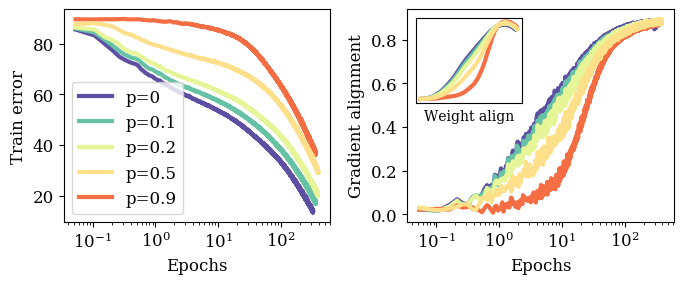

/public/apps/anaconda3/2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


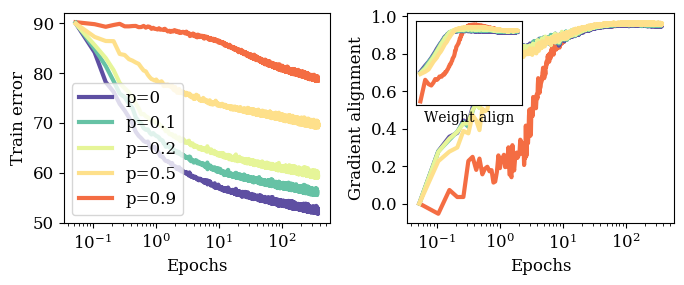

In [210]:
label_key = 'label_noise'
legend_key = 'p'
x = params[label_key]

for dataset in ['MNIST','CIFAR10']:
    for activation in ['relu', 'tanh', 'linear']:

        constraints = {'dataset' : dataset,
                      'activation' : activation,}
        
        selected_runs, _ = select_runs(runs, params, constraints)
        grouped_runs = group_runs(selected_runs, finished_only=True)

        fig, axarr = plt.subplots(1,2, figsize=(7,3))
        axins = inset_axes(axarr[1], width='40%', height='40%', loc=2)
        
        n_steps = len(runs[0]['test_loss'])
        for group in grouped_runs:
            args = group[0]['args']
            i = find(x,getattr(args, label_key))
            train_acc = np.mean([run['train_accs']  for run in group], axis=0)
            test_acc = np.mean([run['test_accs']  for run in group], axis=0)
            wa = np.mean([run['weight_alignments']['total'] for run in group], axis=0)
            ga = np.mean([run['grad_alignments']['total'] for run in group], axis=0)
            t = np.array(range(1,len(train_acc)+1))*args.log_every*args.batch_size/60000
            label=getattr(args, label_key)
            color=cmap(i/len(x))
            axarr[0].semilogx(t, 100-train_acc, color=color, label=label)
            axarr[1].semilogx(t, ga,           color=color, label=label)
            axins.semilogx(t, wa,           color=color, label=label)
        handles, labels = axarr[0].get_legend_handles_labels()
        handles, labels = zip(*[ (handles[i], labels[i]) for i in sorted(range(len(handles)), key=lambda k: list(map(float,labels))[k])] )
        labels = ['{}={}'.format(legend_key, label) for label in labels]
        axarr[0].legend(handles, labels)
        for ax in axarr: 
            ax.set_xlabel('Epochs')
            #ax.set_xlim(right=100)
        axarr[0].set_ylabel('Train error')
        axarr[1].set_ylabel('Gradient alignment')
        #axins.set_title('Grad alignment')
        axins.text(.5,-.2,'Weight align', horizontalalignment='center',transform=axins.transAxes, fontsize=10)
        axins.set_xticks([])
        axins.set_yticks([])
        #axarr[1].set_ylabel('Test error')
        #axarr[2].set_ylabel('Weight alignment layer 1')
        #axarr[3].set_ylabel('Weight alignment layer 2')

        #plt.suptitle('{} {}'.format(args.dataset, args.activation))
        plt.tight_layout()
        plt.savefig(savedir+'Noise_dynamics_{}_{}.pdf'.format(args.dataset, args.activation), bbox_inches='tight')
        plt.show()

# Teacher student

In [291]:
#paths = sorted(glob.glob('r.*'), key=os.path.getmtime)
#path = paths[-1]+'/'
#print(path)
path = 'r.1601983411/'
runs, params = load_runs(path)

seed range(0, 5)
label_noise [0.0]
hidden_size [100]
n_layers [3]
activation ['linear', 'tanh', 'relu']
dataset ['RANDOM']
epochs [10000]
log_every [100]
training_method ['DFA']
feedback_init ['UNIFORM']
weight_init ['UNIFORM']
learning_rate [0.001]
momentum [0.0]
batch_size [32]
test_batch_size [1000]
model ['fc']
no_gpu [True]
dataset_path ['~/data']
datasize [1000]
num_classes [2]
input_dim [9]
optimizer ['SGD']
task ['REGRESSION']
alpha [0.2, 0.4, 0.6, 0.8, 1.0]
beta [0.2, 0.4, 0.6, 0.8, 1.0]
0 out of 375
93 out of 375
186 out of 375
279 out of 375
372 out of 375


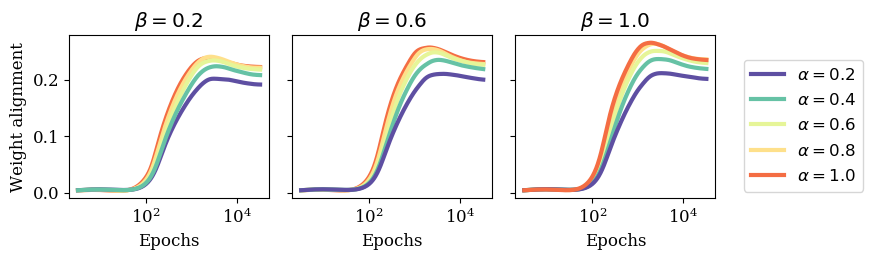

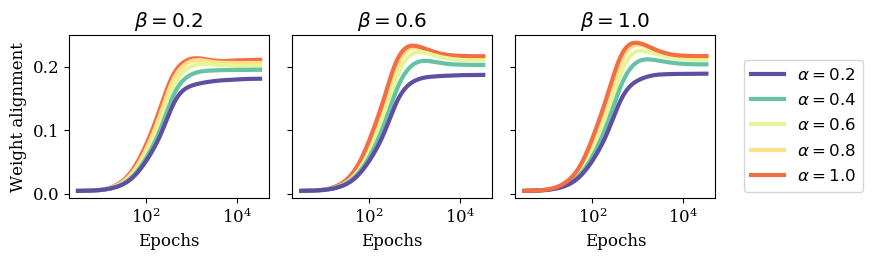

In [254]:
key1 = 'beta'
key2 = 'alpha'
new_params = copy.deepcopy(params)
new_params[key1]=params[key1][::2]

for dataset in ['RANDOM']:
    for activation in ['tanh', 'relu']:

        constraints = {'dataset' : dataset,
                      'activation' : activation}
        
        selected_runs, _ = select_runs(runs, new_params, constraints)
        grouped_runs = group_runs(selected_runs, finished_only=True)

        fig, axarr = plt.subplots(1, len(new_params[key1]), figsize=(3*len(new_params[key1]),3), sharey=True)
#        axinsarr = [inset_axes(ax, width='40%', height='40%', loc=2) for ax in axarr]
        n_steps = len(runs[0]['test_loss'])
        for group in sorted(grouped_runs, key=lambda x:getattr(x[0]['args'],key1)):
            args = group[0]['args']
            if getattr(args,key1) not in new_params[key1]: continue
            i = find(new_params[key1], getattr(args, key1))
            j = find(new_params[key2], getattr(args, key2))
            wa = np.mean([run['weight_alignments']['total'] for run in group], axis=0)
            ga = np.mean([run['grad_alignments']['total'] for run in group], axis=0)
            tr = np.mean([run['train_loss'] for run in group], axis=0)
            te = np.mean([run['test_loss'] for run in group], axis=0)
            t = np.array(range(1,len(wa)+1))*args.log_every*args.batch_size/args.datasize
            label=getattr(args, key2)
            color=cmap(j/len(new_params[key2]))
            axarr[i].semilogx(t, wa, color=color, label=label)
            #axinsarr[i].semilogx(t, ga, color=color, label=label)
        handles, labels = axarr[-1].get_legend_handles_labels()
        handles, labels = zip(*[ (handles[i], labels[i]) for i in sorted(range(len(handles)), key=lambda k: list(map(float,labels))[k])] )
        labels = [r'$\alpha = {}$'.format(label) for label in labels]
        axarr[-1].legend(handles, labels, bbox_to_anchor=(1.1,.9))

        for i, axins in enumerate(axinsarr): 
            axins.set_xticks=([])
            axins.set_yticks=([])
        for i, ax in enumerate(axarr): 
            ax.set_xlabel('Epochs')
            ax.set_title(r'$\beta = {}$'.format(new_params[key1][i]))
            #ax.set_ylim(bottom=0, top=1)
        axarr[0].set_ylabel('Weight alignment')

        #plt.suptitle('{} {}'.format(args.dataset, args.activation))
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig(savedir+'alphabeta_dynamics_{}.pdf'.format(args.activation), bbox_inches='tight')
        plt.show()

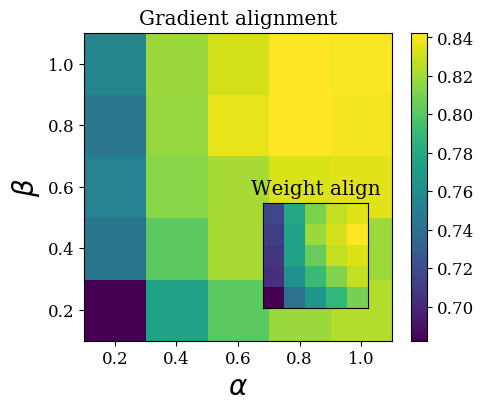

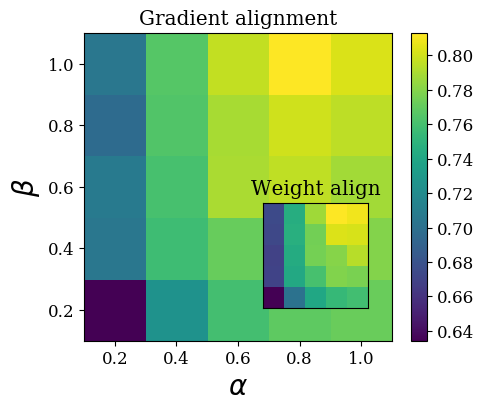

In [293]:
key1 = 'beta'
key2 = 'alpha'

for dataset in ['RANDOM']:
    for activation in ['relu', 'tanh']:

        constraints = {'dataset' : dataset,
                      'activation' : activation}
        
        selected_runs, _ = select_runs(runs, params, constraints)
        grouped_runs = group_runs(selected_runs, finished_only=True)

        fig, ax = plt.subplots(1, figsize=(5,4))      
        axins = inset_axes(ax, width='40%', height='40%', loc=4, bbox_to_anchor=(0.1, 0.05, .85, 1), bbox_transform=ax.transAxes)
        grid_ga = np.zeros((len(params[key1]),len(params[key2])))
        grid_wa = np.zeros((len(params[key1]),len(params[key2])))
        grid_tl = np.zeros((len(params[key1]),len(params[key2])))

        for group in grouped_runs:
            args = group[0]['args']
            i,j = find(params[key1], getattr(args, key1)), find(params[key2], getattr(args, key2))
            grid_tl[i,j] = np.mean([run['train_loss'                ][-1] for run in group])
            grid_ga[i,j] = np.mean([run['grad_alignments']  ['total'][-1] for run in group])
            grid_wa[i,j] = np.mean([run['weight_alignments']['total'][-1] for run in group])
        im1 = ax.imshow( grid_ga, origin='lower', )
        axins.   imshow( grid_wa, origin='lower', )
        plt.colorbar(im1, ax=ax)
        #im2 = axarr[1].contourf(np.array(params[key1]), np.array(params[key2]), grid2)
        #plt.colorbar(im2, ax=axarr[1])
        
        ax.set_title('Gradient alignment')
        ax.set_xlabel(r'$\alpha$',fontsize=20)
        ax.set_ylabel(r'$\beta$' ,fontsize=20)
        ax.set_aspect('equal')
        ax.set_xticklabels(['']+params[key1])
        ax.set_yticklabels(['']+params[key2])        
        
        axins.set_title('Weight align')
        axins.set_xticks([])
        axins.set_yticks([])
        axins.set_aspect('equal')

        plt.savefig(savedir+'alphabeta_{}.pdf'.format(args.activation), bbox_inches='tight')
        plt.show()

# Varying width

In [28]:
path = 'r.1601590379/'
runs, params = load_runs(path)

seed range(0, 10)
hidden_size [ 16  22  32  45  64  90 128 181 256 362 512]
n_layers [4]
activation ['relu', 'tanh']
dataset ['MNIST', 'CIFAR10']
epochs [1000]
training_method ['BP', 'DFA']
feedback_init ['UNIFORM']
weight_init ['UNIFORM']
learning_rate [0.0001]
momentum [0.0]
batch_size [32]
test_batch_size [1000]
model ['fc']
no_gpu [False]
dataset_path ['~/data']
datasize [10000]
num_classes [10]
label_noise [0.0]
input_dim [14]
optimizer ['SGD']
task ['CLASSIFICATION']
0 out of 880
220 out of 880
440 out of 880
660 out of 880


## Statics

width 64: 10 seeds, 10 finished
width 45: 10 seeds, 10 finished
width 45: 10 seeds, 10 finished
width 16: 10 seeds, 10 finished
width 64: 10 seeds, 10 finished
width 22: 10 seeds, 10 finished
width 32: 10 seeds, 10 finished
width 16: 10 seeds, 10 finished
width 32: 10 seeds, 10 finished
width 22: 10 seeds, 10 finished
width 90: 10 seeds, 10 finished
width 90: 10 seeds, 10 finished
width 128: 10 seeds, 10 finished
width 128: 10 seeds, 10 finished
width 181: 10 seeds, 10 finished
width 181: 10 seeds, 10 finished
width 256: 10 seeds, 10 finished
width 256: 10 seeds, 10 finished
width 362: 10 seeds, 10 finished
width 512: 10 seeds, 10 finished
width 512: 10 seeds, 10 finished
width 362: 10 seeds, 10 finished


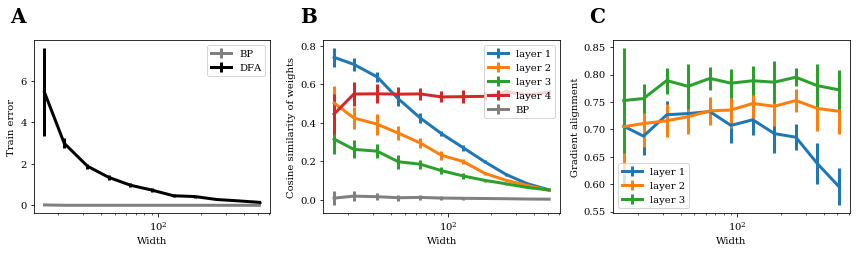

width 32: 10 seeds, 10 finished
width 16: 10 seeds, 10 finished
width 32: 10 seeds, 10 finished
width 45: 10 seeds, 10 finished
width 22: 10 seeds, 10 finished
width 16: 10 seeds, 10 finished
width 45: 10 seeds, 10 finished
width 22: 10 seeds, 10 finished
width 64: 10 seeds, 10 finished
width 90: 10 seeds, 10 finished
width 64: 10 seeds, 10 finished
width 90: 10 seeds, 10 finished
width 128: 10 seeds, 10 finished
width 128: 10 seeds, 10 finished
width 181: 10 seeds, 10 finished
width 181: 10 seeds, 10 finished
width 256: 10 seeds, 0 finished
width 256: 10 seeds, 0 finished
width 362: 10 seeds, 10 finished
width 362: 10 seeds, 10 finished
width 512: 10 seeds, 10 finished
width 512: 10 seeds, 10 finished


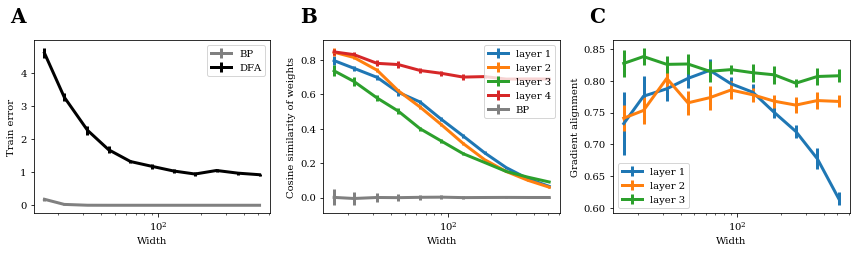

Files already downloaded and verified
Files already downloaded and verified
width 64: 10 seeds, 10 finished
width 16: 10 seeds, 10 finished
width 64: 10 seeds, 10 finished
width 16: 10 seeds, 10 finished
width 22: 10 seeds, 10 finished
width 45: 10 seeds, 10 finished
width 32: 10 seeds, 10 finished
width 32: 10 seeds, 10 finished
width 45: 10 seeds, 10 finished
width 22: 10 seeds, 10 finished
width 90: 10 seeds, 10 finished
width 90: 10 seeds, 10 finished
width 128: 10 seeds, 10 finished
width 128: 10 seeds, 10 finished
width 181: 10 seeds, 10 finished
width 181: 10 seeds, 10 finished
width 256: 10 seeds, 10 finished
width 256: 10 seeds, 10 finished
width 362: 10 seeds, 10 finished
width 512: 10 seeds, 10 finished
width 362: 10 seeds, 10 finished
width 512: 10 seeds, 10 finished


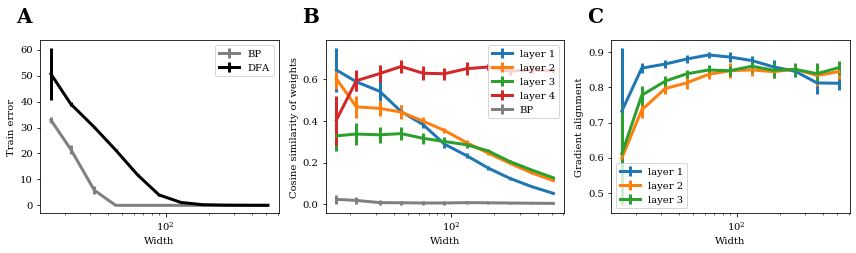

Files already downloaded and verified
Files already downloaded and verified
width 22: 10 seeds, 10 finished
width 32: 10 seeds, 10 finished
width 16: 10 seeds, 10 finished
width 45: 10 seeds, 10 finished
width 16: 10 seeds, 10 finished
width 45: 10 seeds, 10 finished
width 22: 10 seeds, 10 finished
width 32: 10 seeds, 10 finished
width 64: 10 seeds, 10 finished
width 64: 10 seeds, 10 finished
width 90: 10 seeds, 10 finished
width 90: 10 seeds, 10 finished
width 128: 10 seeds, 10 finished
width 128: 10 seeds, 10 finished
width 181: 10 seeds, 10 finished
width 181: 10 seeds, 10 finished
width 256: 10 seeds, 1 finished
width 362: 10 seeds, 10 finished
width 362: 10 seeds, 10 finished
width 256: 10 seeds, 0 finished
width 512: 10 seeds, 10 finished
width 512: 10 seeds, 10 finished


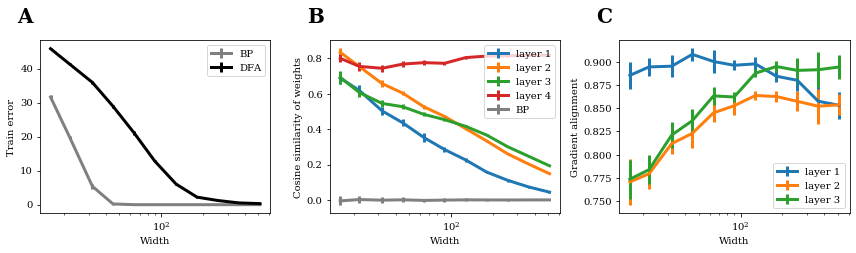

In [61]:
save = True
plot_key = 'hidden_size'
plot_label = 'Width'
log = True
x_var = params[plot_key]

for dataset in ['MNIST','CIFAR10']:
        
    for activation in ['relu', 'tanh']:

        constraints = {'dataset' : dataset,
                       'activation' : activation,
                       'num_classes' : 10}
        selected_runs, params = select_runs(runs, params, constraints)
        grouped_runs = group_runs(selected_runs, finished_only=False)

        args=grouped_runs[0][0]['args']
        train_loader, train_loader_log, test_loader, input_size, output_size, input_channels = get_data(args.dataset, args.dataset_path, args.batch_size, test_batch_size=10000, num_classes=args.num_classes, datasize=None)

        best_test_acc   = {'BP':np.zeros((len(x_var),2)), 'DFA':np.zeros((len(x_var),2))}
        final_test_acc  = {'BP':np.zeros((len(x_var),2)), 'DFA':np.zeros((len(x_var),2))}
        final_ens_acc   = {'BP':np.zeros((len(x_var),2)), 'DFA':np.zeros((len(x_var),2))}
        final_train_acc = {'BP':np.zeros((len(x_var),2)), 'DFA':np.zeros((len(x_var),2))}
        angle           = {'BP':np.zeros((len(x_var),2)), 'DFA':np.zeros((len(x_var),2))}
        grad_overlap = {}
        weight_overlap = {}
        layerwise_angle = {}
        for l in range(runs[0]['args'].n_layers):
            grad_overlap[l] = np.zeros((len(x_var),2))
            weight_overlap[l] = np.zeros((len(x_var),2))
            layerwise_angle[l] = np.zeros((len(x_var),2))

        for igroup, group in enumerate(grouped_runs):
            args = group[0]['args']
            idx = find(params[plot_key],getattr(args, plot_key))
            print('width {}: {} seeds, {} finished'.format(x_var[idx], len(group), len([run for run in group if run['finished']])))
            
            outs = []
            ens_acc = 0#calc_ens_acc(group, test_loader)
            
            best_test_accs=[np.max(run['test_accs']) for run in group]
            final_test_accs =  [   run['test_accs'][-1]    for run in group]
            final_train_accs =   [run['train_accs'][-1]    for run in group]
            best_test_acc[args.training_method][idx]  = [np.mean(best_test_accs),   np.std(best_test_accs)  ]
            final_test_acc[args.training_method][idx] = [np.mean(final_test_accs),  np.std(final_test_accs) ]
            final_train_acc[args.training_method][idx]= [np.mean(final_train_accs), np.std(final_train_accs)]
            final_ens_acc[args.training_method][idx]= ens_acc

            angles = calc_final_angles(group)
            #if len(angles['total'])==0:
                #print(args.name)
            angle[args.training_method][idx] = [np.mean(angles['total']), np.std(angles['total'])]

            if args.training_method=='DFA':
                for l in range(args.n_layers-1):
                    grad_overlaps =   [run['grad_alignments'][l][-1]  for run in group]
                    weight_overlaps = [run['weight_alignments'][l][-1]  for run in group]
                    grad_overlap[l][idx]   = [np.nanmean(grad_overlaps),   np.std(grad_overlaps)  ]
                    weight_overlap[l][idx] = [np.nanmean(weight_overlaps), np.std(weight_overlaps)]
                for l in range(args.n_layers):
                    layerwise_angle[l][idx] = [np.nanmean(angles[l]), np.std(angles[l])]
                    

        #fig, axarr = plt.subplots(1,4,figsize=(14,4))
        fig, axarr = plt.subplots(1,3,figsize=(12,4))

        for i, (k, v) in enumerate(final_train_acc.items()) :
            axarr[0].errorbar(x_var, 100-v[:,0], yerr=v[:,1], color='k' if i else 'grey', label=k)
        axarr[0].legend()
        axarr[0].set_xlabel(plot_key)
        axarr[0].set_ylabel('Train error')
        
#        for i, (k, v) in enumerate(final_test_acc.items()) : 
#            axarr[1].errorbar(x_var, 100-v[:,0], yerr=v[:,1], color='C%d'%i, label=k)
#        axarr[1].plot([],[], color='k', label='final')
#        for i, (k, v) in enumerate(best_test_acc.items()) : 
#            axarr[1].errorbar(x_var, 100-v[:,0], yerr=v[:,1], ls='--', color='C%d'%i)
#        axarr[1].plot([],[], color='k', ls='--', label='early stopping')
#        #for i, (k, v) in enumerate(final_ens_acc.items()) : 
#        #    axarr[1].plot(x_var, 100-v, ls=':', color='C%d'%i)
#        #axarr[1].plot([],[], color='k', ls=':', label='ensembling')
#        axarr[1].set_ylabel('Test error')


        #for k, v in angle.items() :
        axarr[1].set_ylabel('Cosine similarity of weights')
        for l in range(args.n_layers):
            axarr[1].errorbar(x_var, layerwise_angle[l][:,0], yerr=layerwise_angle[l][:,1], label='layer %d'%(l+1))
        axarr[1].errorbar(x_var, angle['BP'][:,0], yerr=angle['BP'][:,1], label='BP', color='grey')

#        for l in range(args.n_layers-1):
#            axarr[2].errorbar(x_var, weight_overlap[l][:,0], yerr=weight_overlap[l][:,1], label='layer %d'%(l+2))
#        axarr[2].set_ylabel('Weight alignment')
        
        for l in range(args.n_layers-1):
            axarr[2].errorbar(x_var, grad_overlap[l][:,0], yerr=grad_overlap[l][:,1], label='layer %d'%(l+1))
        axarr[2].set_ylabel('Gradient alignment')
        
        for i, ax in enumerate(axarr):
            ax.set_xlabel(plot_label)
            ax.legend()
            ax.text(-0.1, 1.1, string.ascii_uppercase[i], transform=ax.transAxes, size=20, weight='bold')
        if log:
            for ax in axarr: ax.set_xscale('log')

        #plt.suptitle('{} {}'.format(args.dataset, args.activation))
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        if save: plt.savefig(savedir+'Results_statics_{}_{}.pdf'.format(args.dataset, args.activation), bbox_inches='tight')
        plt.show()

## Dynamics

In [ ]:
label_key = 'hidden_size'
x = params[label_key]

for dataset in ['MNIST', 'CIFAR10']:
    for activation in ['relu','tanh']:

        constraints = {'dataset' : dataset,
                   'activation' : activation,
                      'num_classes':10}
        
        selected_runs, _ = select_runs(runs, params, constraints)
        grouped_runs = group_runs(selected_runs)

        fig, axarr = plt.subplots(1,4, figsize=(14,4))
        n_steps = len(runs[0]['test_loss'])
        for group in grouped_runs:
            args = group[0]['args']
            i = find(x,getattr(args, label_key))
            try:
                train_acc = np.mean([run['train_accs']           for run in group], axis=0)
                test_acc  = np.mean([run[ 'test_accs']           for run in group], axis=0)
                a1        = np.mean([run['weight_alignments'][2] for run in group], axis=0)
                a2        = np.mean([run['grad_alignments'][2]   for run in group], axis=0)            
            except:
                print('Failed for {} {}'.format(label_key, x[i]))
                continue

            t = np.array(range(1,len(train_acc)+1))*args.log_every
            label=getattr(args, label_key)
            color=cmap(i/len(x))
            if args.training_method == 'BP':
                axarr[0].semilogx(t, 100-train_acc, color=color, label=label)
            else :   
                axarr[1].semilogx(t, 100-train_acc,color=color, label=label)
                axarr[2].semilogx(t, a1,           color=color, label=label)
                axarr[3].semilogx(t, a2,           color=color, label=label)
        #axarr[2].set_ylim(bottom=.5)
        #axarr[3].set_ylim(bottom=.5)
        handles, labels = plt.gca().get_legend_handles_labels()
        handles, labels = zip(*[ (handles[i], labels[i]) for i in sorted(range(len(handles)), key=lambda k: list(map(int,labels))[k])] )
        labels = ['Width = '+label for label in labels]
        plt.legend(handles, labels, bbox_to_anchor=(1.1,1.1))
        for i, ax in enumerate(axarr): 
            ax.set_xlabel('SGD step')
            ax.text(-0.1, 1.1, string.ascii_uppercase[i], transform=ax.transAxes, size=20, weight='bold')
        axarr[0].set_ylabel('BP train error')
        axarr[1].set_ylabel('DFA train error')
        axarr[2].set_ylabel('WA last layer')
        axarr[3].set_ylabel('GA last layer')
    
        print('{} {}'.format(args.dataset, args.activation))
        #plt.suptitle('{} {}'.format(args.dataset, args.activation))
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig(savedir+'Results_dynamics_{}_{}.pdf'.format(args.dataset, args.activation), bbox_inches='tight')
        plt.show()

# Additional experiments

## Effective rank

In [171]:
path = 'r.1602582325/'
runs, params = load_runs(path)

seed range(0, 10)
hidden_size [100]
n_layers [4]
activation ['relu', 'tanh']
dataset ['MNIST', 'CIFAR10']
epochs [10000]
n_saves [40]
training_method ['BP', 'DFA']
feedback_init ['UNIFORM']
weight_init ['UNIFORM']
learning_rate [0.0001]
momentum [0.0]
batch_size [32]
test_batch_size [1000]
model ['fc']
no_gpu [False]
dataset_path ['~/data']
datasize [None]
num_classes [10]
label_noise [0.0, 0.1, 0.2, 0.5, 0.9]
input_dim [14]
optimizer ['SGD']
task ['CLASSIFICATION']
0 out of 400
100 out of 400
200 out of 400
300 out of 400


In [246]:
paths = sorted(glob.glob('r.*'), key=os.path.getmtime)
last = paths[-1]+'/'
path = last
runs, params = load_runs(path)

seed [0]
hidden_size [64]
n_layers [3]
activation ['relu', 'tanh']
dataset ['MNIST', 'CIFAR10', 'CIFAR100']
epochs [1000]
n_saves [40]
training_method ['BP', 'DFA']
feedback_init ['UNIFORM', 'ALIGNED_NMF', 'ALIGNED_SVD']
weight_init ['UNIFORM']
learning_rate [0.001]
momentum [0.0]
batch_size [32]
test_batch_size [1000]
model ['cnn']
no_gpu [False]
dataset_path ['~/data']
datasize [None]
num_classes [None]
label_noise [0.0]
input_dim [14]
optimizer ['SGD']
task ['CLASSIFICATION']
0 out of 36
9 out of 36
18 out of 36
27 out of 36


## Comparing initializations

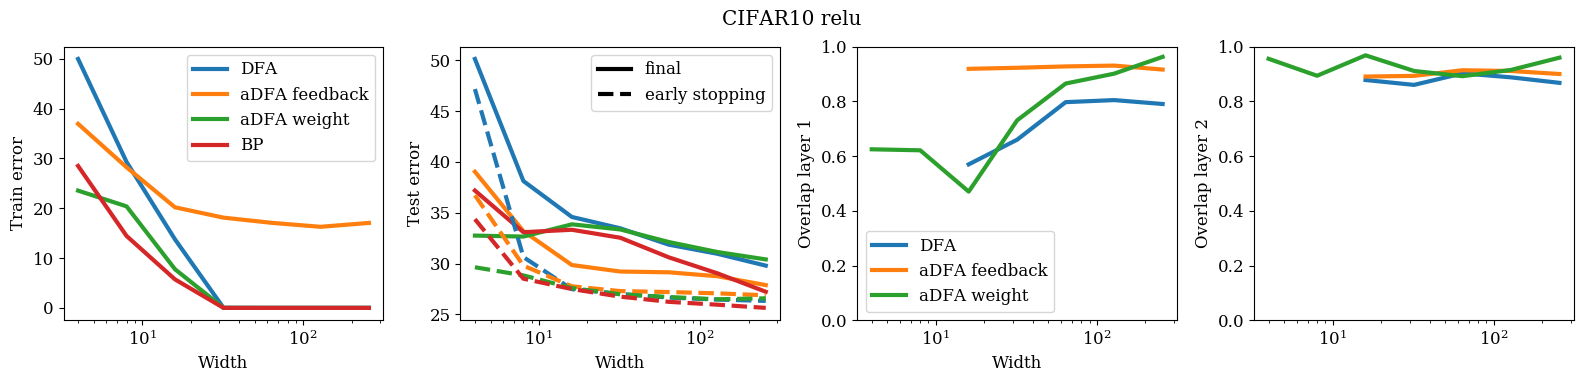

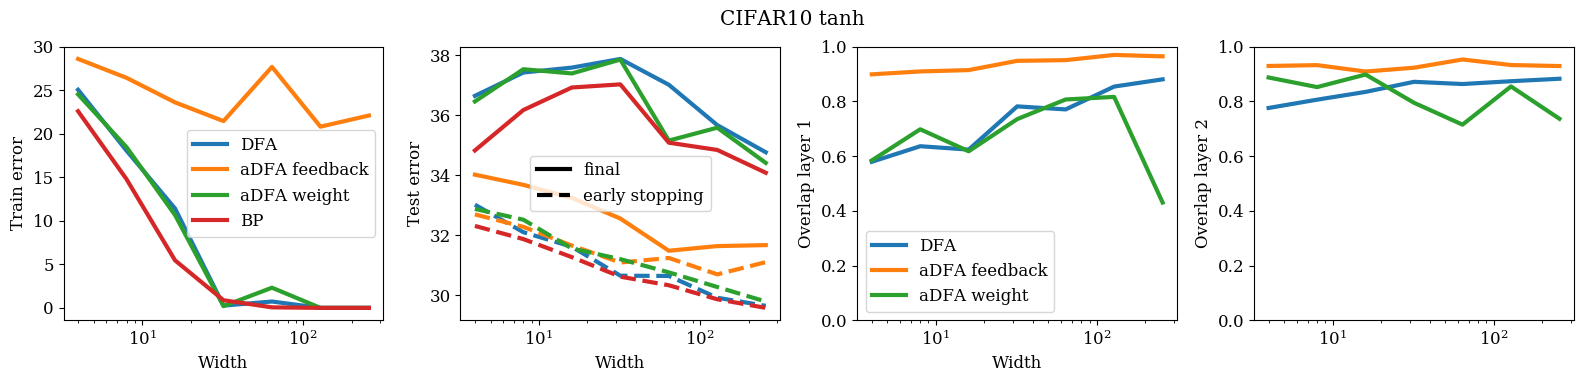

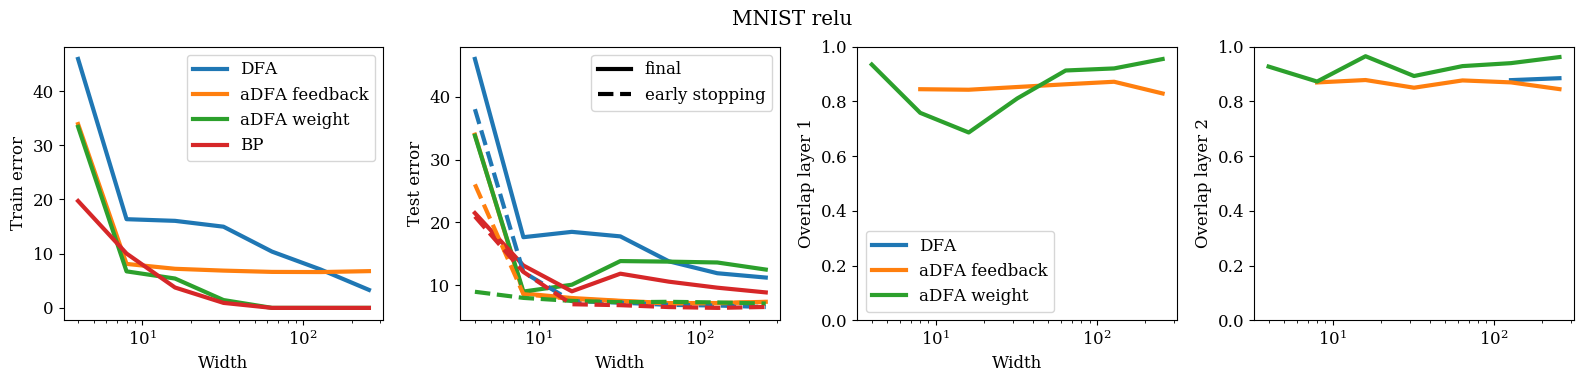

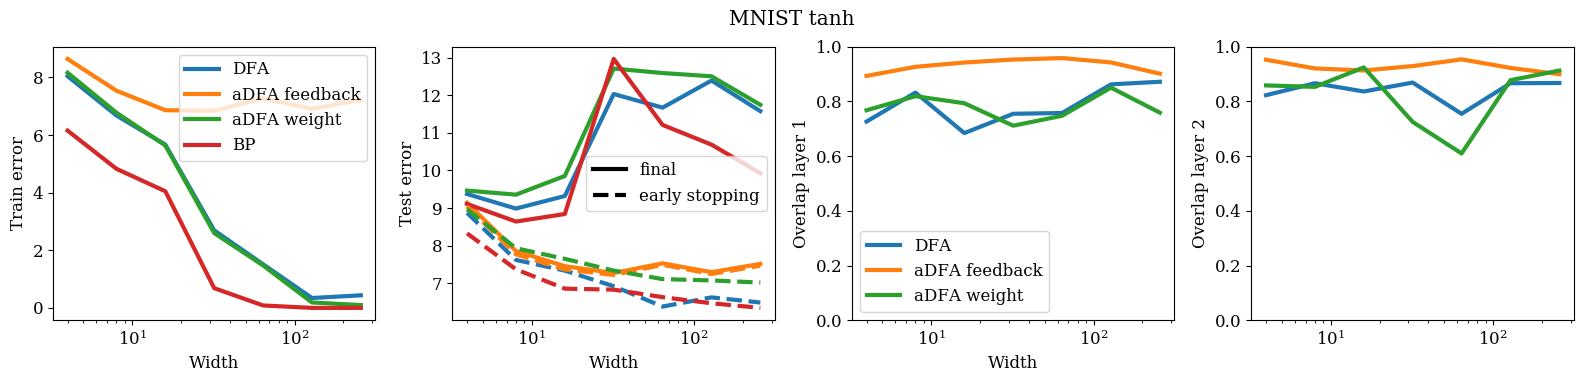

In [199]:
for dataset in ['CIFAR10', 'MNIST']:
    for activation in ['relu', 'tanh']:

        constraints = {'dataset' : dataset,
                   'activation' : activation}
        selected_runs, params = select_runs(runs, params, constraints)
        grouped_runs = group_runs(selected_runs)
        #if only_one_seed: grouped_runs = [[group[0]] for group in grouped_runs]

        x = params['hidden_size']
        best_test_acc = {'DFA':np.zeros(len(x)), 'aDFA feedback':np.zeros(len(x)), 'aDFA weight':np.zeros(len(x)), 'BP':np.zeros(len(x))}
        final_test_acc= {'DFA':np.zeros(len(x)), 'aDFA feedback':np.zeros(len(x)), 'aDFA weight':np.zeros(len(x)), 'BP':np.zeros(len(x))}
        final_train_acc={'DFA':np.zeros(len(x)), 'aDFA feedback':np.zeros(len(x)), 'aDFA weight':np.zeros(len(x)), 'BP':np.zeros(len(x))}
        grad_overlaps1 = {'DFA':np.zeros(len(x)), 'aDFA feedback':np.zeros(len(x)), 'aDFA weight':np.zeros(len(x))}
        grad_overlaps2 = {'DFA':np.zeros(len(x)), 'aDFA feedback':np.zeros(len(x)), 'aDFA weight':np.zeros(len(x))}

        for group in grouped_runs:
            args = group[0]['args']
            i = find(x,args.hidden_size)
            if  args.training_method=='BP':
                key = 'BP'
            elif args.training_method=='DFA':
                key = 'DFA'
                if args.feedback_init=='ALIGNED':
                    key = 'aDFA feedback'
                if args.weight_init=='ALIGNED':
                    key = 'aDFA weight'
                grad_overlaps1[key][i] = np.mean([run['overlaps'][0][-1]  for run in group])
                grad_overlaps2[key][i] = np.mean([run['overlaps'][1][-1]  for run in group])
            best_test_acc [key][i] = np.mean([np.max(run['test_accs'] )  for run in group])
            final_test_acc [key][i] = np.mean([run['test_accs'][-1]  for run in group])
            final_train_acc[key][i] = np.mean([run['train_accs'][-1] for run in group])

        fig, axarr = plt.subplots(1,4,figsize=(16,4))

        for k,v in final_train_acc.items():
            axarr[0].semilogx(x, 100-v, label=k)
        axarr[0].legend()
        axarr[0].set_xlabel('Width')
        axarr[0].set_ylabel('Train error')

        for i, (k, v) in enumerate(final_test_acc.items()) : 
            axarr[1].semilogx(x, 100-v, color='C%d'%i)
        for i, (k, v) in enumerate(best_test_acc.items()) : 
            axarr[1].semilogx(x, 100-v, ls='--', color='C%d'%i)
        axarr[1].plot([],[], color='k', label='final')
        axarr[1].plot([],[], color='k', ls='--', label='early stopping')
        axarr[1].legend()
        axarr[1].set_xlabel('Width')
        axarr[1].set_ylabel('Test error')

        for k, v in grad_overlaps1.items():
            axarr[2].semilogx(x, v, label=k)
        for k, v in grad_overlaps2.items():
            axarr[3].semilogx(x, v, label=k)
            
        axarr[2].legend()
        axarr[2].set_xlabel('Width')
        axarr[2].set_ylabel('Overlap layer 1')
        axarr[3].set_ylabel('Overlap layer 2')
        axarr[2].set_ylim(0,1)
        axarr[3].set_ylim(0,1)

        plt.suptitle('{} {}'.format(args.dataset, args.activation))
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig(savedir+'Results_aligned_init_{}_{}.png'.format(args.dataset, args.activation), bbox_inches='tight')
        plt.show()